# Question Answering with Langchain and OpenAI

<a target="_blank" href="https://colab.research.google.com/github/elastic/elasticsearch-labs/blob/main/notebooks/generative-ai/question-answering.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This interactive notebook uses Langchain to split fictional workplace documents into passages and uses OpenAI to transform these passages into embeddings and store them into Elasticsearch.


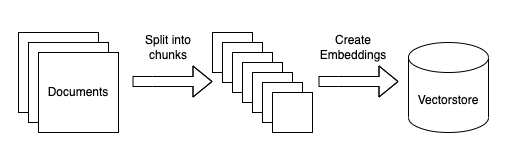

Then when we ask a question, we retrieve the relevant passages from the vector store and use langchain and OpenAI to provide a summary for the question.

## Install required packages


In [1]:
!python3 -m pip install -qU langchain openai==0.28.1 elasticsearch tiktoken jq


[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Connect to Elasticsearch

ℹ️ We're using an Elastic Cloud deployment of Elasticsearch for this notebook. If you don't have an Elastic Cloud deployment, sign up [here](https://cloud.elastic.co/registration?utm_source=github&utm_content=elasticsearch-labs-notebook) for a free trial. 

We'll use the **Cloud ID** to identify our deployment, because we are using Elastic Cloud deployment. To find the Cloud ID for your deployment, go to https://cloud.elastic.co/deployments and select your deployment.


We will use [ElasticsearchStore](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.elasticsearch.ElasticsearchStore.html) to connect to our elastic cloud deployment. This would help create and index data easily. In the ElasticsearchStore instance, will set embedding to [OpenAIEmbeddings](https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.openai.OpenAIEmbeddings.html) to embed the texts and elasticsearch index name that will be used in this example.

In [61]:
from langchain.vectorstores import ElasticsearchStore
from langchain.embeddings.openai import OpenAIEmbeddings
from getpass import getpass

# set elastic cloud id and password

CLOUD_ID = getpass("Elastic deployment Cloud ID")
CLOUD_USERNAME = "elastic"
CLOUD_PASSWORD = getpass("Elastic deployment Password")

# set OpenAI API key
OPENAI_API_KEY = getpass("OpenAI API key")

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

vector_store = ElasticsearchStore(
    es_cloud_id=CLOUD_ID,
    es_user=CLOUD_USERNAME,
    es_password=CLOUD_PASSWORD,
    index_name= "workplace_index",
    embedding=embeddings
)


## Indexing Data into Elasticsearch

Let's download the sample dataset and deserialize the document. 

In [3]:
from urllib.request import urlopen
from langchain.llms import OpenAI
import json

url = "https://raw.githubusercontent.com/elastic/elasticsearch-labs/main/example-apps/workplace-search/data/data.json"

response = urlopen(url)
data = json.load(response)

with open('temp.json', 'w') as json_file:
    json.dump(data, json_file)


### Split Documents into Passages

We’ll chunk documents into passages in order to improve the retrieval specificity and to ensure that we can provide multiple passages within the context window of the final question answering prompt.

Here we are chunking documents into 800 token passages with an overlap of 400 tokens.

Here we are using a simple splitter but Langchain offers more advanced splitters to reduce the chance of context being lost.

In [40]:
from langchain.document_loaders import JSONLoader 
from langchain.text_splitter import RecursiveCharacterTextSplitter

def metadata_func(record: dict, metadata: dict) -> dict:
    metadata["name"] = record.get("name")
    metadata["summary"] = record.get("summary")
    metadata["url"] = record.get("url")
    metadata["category"] = record.get("category")
    metadata["updated_at"] = record.get("updated_at")

    return metadata

# For more loaders https://python.langchain.com/docs/modules/data_connection/document_loaders/
# And 3rd party loaders https://python.langchain.com/docs/modules/data_connection/document_loaders/#third-party-loaders
loader = JSONLoader(
    file_path="temp.json",
    jq_schema=".[]",
    content_key="content",
    metadata_func=metadata_func,
)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=200)
docs = loader.load_and_split(text_splitter=text_splitter)

### Bulk Import Passages

Now that we have split each document into the chunk size of 800, we will now index data to elasticsearch using [ElasticsearchStore.from_documents](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.elasticsearch.ElasticsearchStore.html#langchain.vectorstores.elasticsearch.ElasticsearchStore.from_documents).

We will use Cloud ID,  Password and Index name values set in the `Create cloud deployment` step.

In [41]:
documents = vector_store.from_documents(
    docs, 
    embeddings,  
    index_name="workplace_index",
    es_cloud_id=CLOUD_ID,
    es_user=CLOUD_USERNAME,
    es_password=CLOUD_PASSWORD
)

## Asking a question
Now that we have the passages stored in Elasticsearch, we can now ask a question to get the relevant passages.

In [62]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

retriever = vector_store.as_retriever()

llm = OpenAI(openai_api_key=OPENAI_API_KEY)

ANSWER_PROMPT = ChatPromptTemplate.from_template(
    """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Be as verbose and educational in your response as possible. 
    
    context: {context}
    Question: "{question}"
    Answer:
    """
)

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | ANSWER_PROMPT
    | llm
    | StrOutputParser()
)

ans = chain.invoke("what is the nasa sales team?")

print("---- Answer ----")
print(ans)

---- Answer ----

The NASA Sales Team is the regional sales team that covers the North America and South America region. It is led by two Area Vice-Presidents, Laura Martinez (for North America) and Gary Johnson (for South America). The team consists of dedicated account managers, sales representatives, and support staff who are responsible for identifying and pursuing new business opportunities, nurturing existing client relationships, and ensuring customer satisfaction. The team also collaborates with other departments, such as marketing, product development, and customer support to ensure the delivery of high-quality products and services to clients.


### Add Source Tracing
RAG can provide clear traceability of the source knowledge used to answer a question. This is important for compliance and regulatory reasons and limiting LLM hallucinations. This is known as source tracking.

In this example, we extend the Prompt template to ask the LLM to cite the source of the answer.

In [68]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema import format_document

retriever = vector_store.as_retriever()

llm = OpenAI(openai_api_key=OPENAI_API_KEY)

ANSWER_PROMPT = ChatPromptTemplate.from_template(
"""
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Be as verbose and educational in your response as possible. 
Each passage has a SOURCE which is the title of the document. When answering, cite source name of the passages you are answering from below the answer, on a new line, with a prefix of "SOURCE:".


context: {context}
Question: "{question}"
Answer:
"""
)

DOCUMENT_PROMPT = PromptTemplate.from_template("""
---
SOURCE: {name}
{page_content}
---
""")

def _combine_documents(
    docs, document_prompt=DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

_context = {
    "context":  retriever | _combine_documents,
    "question": RunnablePassthrough(),
}

chain = (
    _context
    | ANSWER_PROMPT
    | llm
    | StrOutputParser()
)

ans = chain.invoke("what is the nasa sales team?")

print("---- Answer ----")
print(ans)

---- Answer ----
The NASA sales team is the North America South America (NASA) region of the company's sales organization. This region includes the United States, Canada, Mexico, as well as Central and South America. The NASA sales team is composed of dedicated account managers, sales representatives, and support staff, led by their respective Area Vice-Presidents. The team's role is to identify and pursue new business opportunities, nurture existing client relationships, and ensure customer satisfaction. They collaborate closely with other departments, such as marketing, product development, and customer support, to ensure the company consistently delivers high-quality products and services to their clients.

SOURCE: Sales Organization Overview


### Returning Passages with Answer

In this example, we extend the chain to return the passages back with the answer. This is helpful for the UI to display the source passages, should the user want to read more on the topic. 

In [70]:
from langchain.schema.runnable import RunnableMap
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.schema import format_document
from operator import itemgetter

retriever = vector_store.as_retriever()

llm = OpenAI(openai_api_key=OPENAI_API_KEY)

ANSWER_PROMPT = ChatPromptTemplate.from_template(
"""
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Be as verbose and educational in your response as possible. 
Each passage has a SOURCE which is the title of the document. When answering, cite source name of the passages you are answering from below the answer, on a new line, with a prefix of "SOURCE:".

context: {context}
Question: {question}
Answer:

"""
)

DOCUMENT_PROMPT = PromptTemplate.from_template("""
---
SOURCE: {name}
{page_content}
---
""")

def _combine_documents(
    docs, document_prompt=DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

retrieved_documents = RunnableMap(
    docs=itemgetter("question") | retriever,
    question=itemgetter("question"),
)

_context = {
    "context": lambda x: _combine_documents(x["docs"]),
    "question": lambda x: x["question"],
}

answer = {
    "answer": _context | ANSWER_PROMPT | llm,
    "docs": itemgetter("docs"),
}

chain = (
    retrieved_documents | answer
)

ans = chain.invoke({ "question": "what is the nasa sales team?"})

print("---- Answer ----")
print(ans["answer"])
print()
print("---- Documents ----")
for doc in ans["docs"]:
  print(doc.metadata["name"])
  print(doc.page_content)
  print("----")


---- Answer ----
The NASA Sales Team is the sales team in charge of the North America South America region (NASA) which consists of the United States, Canada, Mexico, as well as Central and South America. The team is led by two Area Vice-Presidents: Laura Martinez is the Area Vice-President of North America, and Gary Johnson is the Area Vice-President of South America. The team is responsible for identifying and pursuing new business opportunities, nurturing existing client relationships, and ensuring customer satisfaction. They collaborate closely with other departments, such as marketing, product development, and customer support, to ensure the company delivers high-quality products and services to their clients. 

SOURCE: Sales Organization Overview

---- Documents ----
Sales Organization Overview
Our sales organization is structured to effectively serve our customers and achieve our business objectives across multiple regions. The organization is divided into the following main reg

### Conversational Question Answering
We have achieved getting answers to questions, but what if we want to ask follow up questions? We can use the answer from the previous question as the context for the next question. This is known as conversational question answering.

In this example, we extend the chain to use the answer from the previous question as the context for the next question.

In [75]:
from langchain.schema.runnable import RunnableMap
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.schema import format_document
from operator import itemgetter

retriever = vector_store.as_retriever()

llm = OpenAI(openai_api_key=OPENAI_API_KEY)

ANSWER_PROMPT = ChatPromptTemplate.from_template(
"""
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Be as verbose and educational in your response as possible. 
Each passage has a SOURCE which is the title of the document. When answering, cite source name of the passages you are answering from below the answer, on a new line, with a prefix of "SOURCE:".

context: 
{context}

Question: {question}
Answer:
"""
)

DOCUMENT_PROMPT = PromptTemplate.from_template("""
---
SOURCE: {name}
{page_content}
---
""")

CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(
"""Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:
{chat_history}
Follow Up Input: {question}
""")

standalone_question = RunnableMap(
    standalone_question=RunnablePassthrough.assign(
        chat_history=lambda x: _format_chat_history(x["chat_history"])
    )
    | CONDENSE_QUESTION_PROMPT
    | llm
    | StrOutputParser(),
)

def _format_chat_history(chat_history) -> str:
    buffer = ""
    for dialogue_turn in chat_history:
        human = "Human: " + dialogue_turn[0]
        ai = "Assistant: " + dialogue_turn[1]
        buffer += "\n" + "\n".join([human, ai])
    return buffer

def _combine_documents(
    docs, document_prompt=DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

retrieved_documents = RunnableMap(
    docs=itemgetter("standalone_question") | retriever,
    question=itemgetter("standalone_question"),
)

_context = {
    "context": lambda x: _combine_documents(x["docs"]),
    "question": lambda x: x["question"],
}

answer = {
    "answer": _context | ANSWER_PROMPT | llm,
    "docs": itemgetter("docs"),
}

chain = (
    standalone_question | retrieved_documents | answer
)

ans = chain.invoke({ 
  "question": "What are their objectives?", 
  "chat_history": [
    "What is the nasa sales team?",
    "The sales team of NASA consists of Laura Martinez, the Area "
    "Vice-President of North America, and Gary Johnson, the Area "
    "Vice-President of South America."
    "SOURCE: Sales Organization Overview"
  ]
})

print("---- Answer ----")
print(ans["answer"])

---- Answer ----
The objectives for Fiscal Year 2024 are to increase revenue by 20% compared to Fiscal Year 2023, expand market share in key segments by 15%, retain 95% of existing customers and increase customer satisfaction ratings, and launch at least two new products or services in high-demand market segments. 
SOURCE: Fy2024 Company Sales Strategy - I. Objectives for Fiscal Year 2024


## Next Steps
We have shown how to use Langchain to build a question answering system. We have shown how to index data into Elasticsearch, ask a question and use the answer from the previous question as the context for the next question.